# Loan Default Prediction - Part 17 - Neural Networks with Multiple Outputs

This is an exploratory project for me to apply what I have learned in the Data Science and Machine Learning courses that I took this year. The data is from a Kaggle competition [Loan Default Prediction](https://www.kaggle.com/c/loan-default-prediction). 

This is Part 17 of the project: Neural Networks with Multiple Outputs.

I have been working on the binary classification version of the loan default prediction problem. However, the original dataset also contains the percentage of loan not paid for, which is a regression problem. In this part, I will add a regression output in the neural network to predict the percentage.

I will first load the normalized data.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import time
import project_utils as utils
import project_keras_utils as keras_utils

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# We need two sets of labels now, one for classification and one for regression

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    df = df.drop(['id', 'Unnamed: 0'], axis=1) # Dropping the ID column
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    X = df.drop(['loss'], axis=1) # Features
    y1 = (df.loc[:,'loss'] > 0) # Labels
    y2 = df.loc[:,'loss']
    if describe:
        print(X.shape, y1.shape, y2.shape)
    
    return df, X, y1, y2

In [3]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y1, y2 = load_csv('train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y1_train, X_valid, y1_valid = utils.split_data(kf, X, y1)
X_train, y2_train, X_valid, y2_valid = utils.split_data(kf, X, y2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1789)
memory usage: 1.4 GB


## Adding More Hidden Layers

I will base my implementation on the last part, but add some more hidden layers.

In [4]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout

In [5]:
# Define parameters

n_features = X.shape[1]
n_epochs = 30
batch_size = 256
class_weight = {0: 1., 1: 10.}

I will make an arbitrary two-output neural network with some of the layers being shared.

In [6]:
# Build Keras model

inputs = Input(shape=(n_features,), name='input')
x = Dense(36, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = Dense(18, activation='relu')(x)
x = Dropout(0.5)(x)
x1 = Dense(6, activation='relu')(x)
x1 = Dropout(0.5)(x1)
class_output = Dense(1, activation='sigmoid', name='class_output')(x1)
x2 = keras.layers.concatenate([x, class_output])
x2 = Dense(6, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
regress_output = Dense(1, activation='relu', name='regress_output')(x2)
clf = Model(inputs=inputs, outputs=[class_output, regress_output])

clf.compile(loss={'class_output': 'binary_crossentropy', 'regress_output': 'mean_squared_error'},
            loss_weights={'class_output': 1., 'regress_output': 0.1},
            optimizer=keras.optimizers.Adamax(lr=0.001),
            metrics=['binary_accuracy', 'mse'])

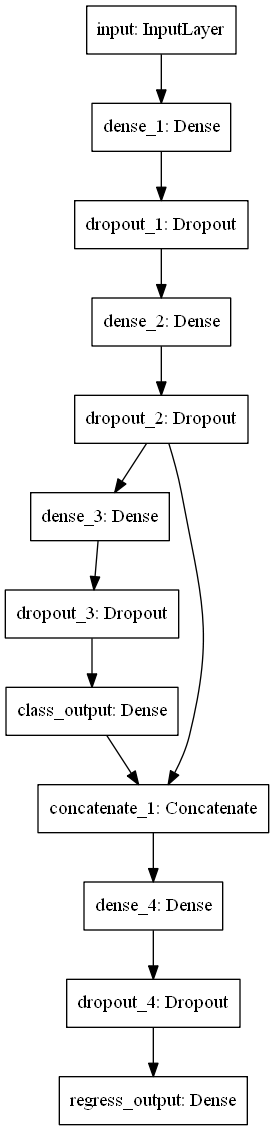

In [7]:
# Plot the model

from keras.utils import plot_model
plot_model(clf, to_file='model.png')

from IPython.display import Image
Image("model.png")

In [17]:
import time
import matplotlib.pyplot as plt
from sklearn import metrics

def evaluate (clf, X_train, y1_train, y2_train, X_valid, y1_valid, y2_valid, plot=True):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')

    start = time.time()

    # Training set    
    y_train_predicted = clf.predict(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y1_train.values, y_train_predicted[0])
    precision, recall, thresholds = metrics.precision_recall_curve(y1_train.values, y_train_predicted[0])
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Classification Accuracy (Training): %f' % metrics.accuracy_score(y1_train.values, np.ndarray.round(y_train_predicted[0])))
    print('Regression MSE (Training): %f' % metrics.mean_squared_error(y2_train.values, y_train_predicted[1]))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y1_train.values, y_train_predicted[0]))
    print('PRAUC Score (Training): %f' % metrics.auc(precision, recall, reorder=True))

    # Validation set
    y_valid_predicted = clf.predict(X_valid)    
    fpr, tpr, thresholds = metrics.roc_curve(y1_valid, y_valid_predicted[0])
    precision, recall, thresholds = metrics.precision_recall_curve(y1_valid.values, y_valid_predicted[0])
    plt1.scatter(fpr, tpr, color='r')
    plt2.scatter(precision, recall,color='r')
    acc_score = metrics.accuracy_score(y1_valid.values, np.ndarray.round(y_valid_predicted[0]))
    print('Classification Accuracy (Validation): %f' % acc_score)
    mse_score = metrics.mean_squared_error(y2_valid.values, y_valid_predicted[1])
    print('Regression MSE (Validation): %f' % mse_score)
    rocauc_score = metrics.roc_auc_score(y1_valid.values, y_valid_predicted[0])
    print('ROCAUC Score (Validation): %f' % rocauc_score)
    prauc_score = metrics.auc(precision, recall, reorder=True)
    print('PRAUC Score (Validation): %f' % prauc_score)

    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    if plot:
        plt.show()
    plt.close()
    
    return acc_score, rocauc_score, prauc_score, eval_time

In [11]:
# Train and evaluate the model with class weights

fit_time = keras_utils.train_model(clf, X_train, [y1_train, y2_train], n_epochs, batch_size, class_weight)

Epoch 1/30
84376/84376 [==============================] - 6s 76us/step - loss: 2.1359 - class_output_loss: 0.2986 - regress_output_loss: 18.3727 - class_output_binary_accuracy: 0.9061 - class_output_mean_squared_error: 0.0830 - regress_output_binary_accuracy: 0.0620 - regress_output_mean_squared_error: 18.3727
Epoch 2/30
84376/84376 [==============================] - 6s 74us/step - loss: 2.1355 - class_output_loss: 0.2985 - regress_output_loss: 18.3703 - class_output_binary_accuracy: 0.9061 - class_output_mean_squared_error: 0.0830 - regress_output_binary_accuracy: 0.0615 - regress_output_mean_squared_error: 18.3703
Epoch 3/30
84376/84376 [==============================] - 6s 73us/step - loss: 2.1338 - class_output_loss: 0.2974 - regress_output_loss: 18.3640 - class_output_binary_accuracy: 0.9061 - class_output_mean_squared_error: 0.0829 - regress_output_binary_accuracy: 0.0585 - regress_output_mean_squared_error: 18.3640
Epoch 4/30
84376/84376 [==============================] - 7s 80u

84376/84376 [==============================] - 7s 84us/step - loss: 2.1247 - class_output_loss: 0.2906 - regress_output_loss: 18.3406 - class_output_binary_accuracy: 0.9061 - class_output_mean_squared_error: 0.0819 - regress_output_binary_accuracy: 0.1053 - regress_output_mean_squared_error: 18.3406
Epoch 28/30
84376/84376 [==============================] - 7s 85us/step - loss: 2.1205 - class_output_loss: 0.2891 - regress_output_loss: 18.3141 - class_output_binary_accuracy: 0.9061 - class_output_mean_squared_error: 0.0816 - regress_output_binary_accuracy: 0.1147 - regress_output_mean_squared_error: 18.3141
Epoch 29/30
84376/84376 [==============================] - 7s 80us/step - loss: 2.1208 - class_output_loss: 0.2892 - regress_output_loss: 18.3158 - class_output_binary_accuracy: 0.9061 - class_output_mean_squared_error: 0.0816 - regress_output_binary_accuracy: 0.1167 - regress_output_mean_squared_error: 18.3158
Epoch 30/30
84376/84376 [==============================] - 7s 81us/step -

Classification Accuracy (Training): 0.906111
Regression MSE (Training): 18.284689
ROCAUC Score (Training): 0.765695
PRAUC Score (Training): 0.122907
Classification Accuracy (Validation): 0.911827
Regression MSE (Validation): 19.857308
ROCAUC Score (Validation): 0.691035
PRAUC Score (Validation): 0.071805
Time elapsed (Evaluation): 4.6545 s


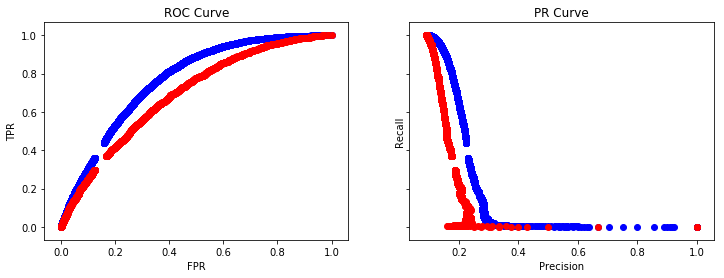

In [18]:
acc_score, rocauc_score, prauc_score, eval_time = evaluate(clf, X_train, y1_train, y2_train, X_valid, y1_valid, y2_valid)

## With Discretized Features from Random Forests

In [24]:
# We need two sets of labels now, one for classification and one for regression

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    X = df.drop(['loss'], axis=1) # Features
    y1 = (df.loc[:,'loss'] > 0) # Labels
    y2 = df.loc[:,'loss']
    if describe:
        print(X.shape, y1.shape, y2.shape)
    
    return df, X, y1, y2

In [25]:
# Load the training data (normalized) with random forest paths as features from the CSV file
df, X, y1, y2 = load_csv('train_v2_normalized_with_rf_path.csv')

X_train, y1_train, X_valid, y1_valid = utils.split_data(kf, X, y1)
X_train, y2_train, X_valid, y2_valid = utils.split_data(kf, X, y2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 3032 entries, Unnamed: 0 to loss
dtypes: float64(1789), int64(1243)
memory usage: 2.4 GB


In [27]:
# Redefine input size

n_features = X.shape[1]

In [31]:
# Build Keras model

inputs = Input(shape=(n_features,), name='input')
x = Dense(36, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Dense(18, activation='relu')(x)
x = Dropout(0.2)(x)
x1 = Dense(6, activation='relu')(x)
x1 = Dropout(0.2)(x1)
class_output = Dense(1, activation='sigmoid', name='class_output')(x1)
x2 = keras.layers.concatenate([x, class_output])
x2 = Dense(6, activation='relu')(x2)
x2 = Dropout(0.2)(x2)
regress_output = Dense(1, activation='relu', name='regress_output')(x2)
clf = Model(inputs=inputs, outputs=[class_output, regress_output])

clf.compile(loss={'class_output': 'binary_crossentropy', 'regress_output': 'mean_squared_error'},
            loss_weights={'class_output': 1., 'regress_output': 0.1},
            optimizer=keras.optimizers.Adamax(lr=0.001),
            metrics=['binary_accuracy', 'mse'])

In [32]:
fit_time = keras_utils.train_model(clf, X_train, [y1_train, y2_train], n_epochs, batch_size, class_weight)

Epoch 1/30
84376/84376 [==============================] - 12s 147us/step - loss: 410.3776 - class_output_loss: 3.3057 - regress_output_loss: 4070.7189 - class_output_binary_accuracy: 0.7888 - class_output_mean_squared_error: 0.2157 - regress_output_binary_accuracy: 0.8826 - regress_output_mean_squared_error: 4070.7189
Epoch 2/30
84376/84376 [==============================] - 12s 139us/step - loss: 44.1932 - class_output_loss: 2.8149 - regress_output_loss: 413.7838 - class_output_binary_accuracy: 0.8190 - class_output_mean_squared_error: 0.1864 - regress_output_binary_accuracy: 0.8963 - regress_output_mean_squared_error: 413.7838
Epoch 3/30
84376/84376 [==============================] - 13s 156us/step - loss: 17.4033 - class_output_loss: 2.2782 - regress_output_loss: 151.2514 - class_output_binary_accuracy: 0.8507 - class_output_mean_squared_error: 0.1561 - regress_output_binary_accuracy: 0.9002 - regress_output_mean_squared_error: 151.2514
Epoch 4/30
84376/84376 [======================

Epoch 27/30
84376/84376 [==============================] - 11s 125us/step - loss: 3.2233 - class_output_loss: 1.3014 - regress_output_loss: 19.2188 - class_output_binary_accuracy: 0.9047 - class_output_mean_squared_error: 0.0936 - regress_output_binary_accuracy: 0.9059 - regress_output_mean_squared_error: 19.2188
Epoch 28/30
84376/84376 [==============================] - 10s 124us/step - loss: 3.2139 - class_output_loss: 1.2903 - regress_output_loss: 19.2360 - class_output_binary_accuracy: 0.9049 - class_output_mean_squared_error: 0.0932 - regress_output_binary_accuracy: 0.9060 - regress_output_mean_squared_error: 19.2360
Epoch 29/30
84376/84376 [==============================] - 12s 136us/step - loss: 3.2146 - class_output_loss: 1.2927 - regress_output_loss: 19.2195 - class_output_binary_accuracy: 0.9048 - class_output_mean_squared_error: 0.0934 - regress_output_binary_accuracy: 0.9059 - regress_output_mean_squared_error: 19.2195
Epoch 30/30
84376/84376 [==============================

Classification Accuracy (Training): 0.906099
Regression MSE (Training): 19.019401
ROCAUC Score (Training): 0.500000
PRAUC Score (Training): 0.453049
Classification Accuracy (Validation): 0.911827
Regression MSE (Validation): 20.478502
ROCAUC Score (Validation): 0.495006
PRAUC Score (Validation): 0.002271
Time elapsed (Evaluation): 13.5708 s


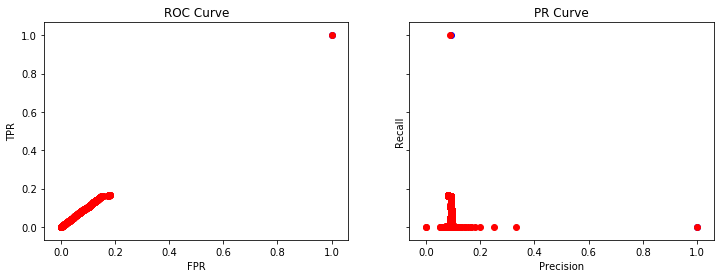

In [33]:
acc_score, rocauc_score, prauc_score, eval_time = evaluate(clf, X_train, y1_train, y2_train, X_valid, y1_valid, y2_valid)